In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [2]:
# # # # MTS COVARIATES # # # #

p = os.path.join(DATA_DIR,'raw', 'Covid19_01262020_09262020.csv')
df = pd.read_csv(p)
# df

cols = [x for x in df.columns if x not in ['index','Date','confirmed_cases','deaths','foot_traffic']]
df = df[cols]

df['Fips'] = df.GISJOIN.apply(lambda x: x[1:3] + x[4:-1])
df['Fips'] = df.Fips.apply(lambda x: int(x))
df.drop_duplicates(inplace=True)
df.drop('GISJOIN',axis=1,inplace=True)
df.set_index('Fips',inplace=True,drop=True)


# # # # DEATH DATA # # # #

timestamp = '20241009-144131'

fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df_deaths = pd.read_csv(fpath)
## Drop rows with nans.
df_deaths.dropna(inplace=True)
## Drop samples with negative inc deaths.
df_deaths = df_deaths[df_deaths.True_inc_deaths >= 0]

df = df_deaths.join(df,on='Fips')
# df = df[df.Date < 20210626]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,OCCU1,OCCU2,OCCU3,OCCU4,OCCU5,DT,HD,HT,WI,OB
1,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
2,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
3,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
4,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
5,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309954,56045,56,6891.0,576641,0.011950,20220409,8.000000,18.0,18.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309955,56045,56,6891.0,576641,0.011950,20220416,5.000000,18.0,18.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309956,56045,56,6891.0,576641,0.011950,20220423,4.000000,18.0,18.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309957,56045,56,6891.0,576641,0.011950,20220430,4.000000,18.0,18.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9


In [4]:
from epsampling.modeling import get_full_modeling_dfs

# df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')

# df = df[df.True_inc_deaths > 0]

df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
df['State_deaths'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)

### <font color=blue> Add previous naive deaths to features.

In [5]:
from tqdm import tqdm

dates = sorted(df.Date.unique())

# # # # # # # # # # # # # # # 
num_weeks_from = 0
num_weeks_to = 15
# # # # # # # # # # # # # # # 

for i in range(num_weeks_from, num_weeks_to):
    df[f'Weeks_ago_{i+1}'] = None


# # # # # # # # # # # # # # 
fipss = df.Fips.unique()
# # # # # # # # # # # # # # 

dfs = []
for fips in tqdm(fipss,total=len(fipss)):
    df_county = df[df.Fips==fips] 
    df_county.sort_values('Date',inplace=True)
    df_county.reset_index(inplace=True,drop=True)

    for i in range(len(df_county)):

        if i < num_weeks_to:
            continue
        else:

            # # # # # # # # # # # # # # 
            from_date = i - num_weeks_from #num_weeks_from, 4
            to_date = i - num_weeks_to #num_weeks_to, 9
            # # # # # # # # # # # # # # 
            
            this = df_county[to_date:from_date]['Naive'].values[::-1]
            wk_to_death = { f'Weeks_ago_{k+1}':v for (k,v) in zip(range(num_weeks_from,num_weeks_to),this) }
            df_county.loc[i, wk_to_death.keys()] = wk_to_death.values()

    dfs.append(df_county)

100%|██████████| 3107/3107 [11:06<00:00,  4.67it/s]


In [6]:
meow()

In [6]:
df_tot = pd.concat(dfs)
df_tot.reset_index(inplace=True,drop=True)

from datetime import datetime
d = datetime.today().strftime('%Y%m%d-%H%M%S')
df_tot.to_csv(f'{DATA_DIR}cached/df_modeling_pastweeks_{d}.csv',index=False)
print(d)
# 20241029-040951
# 20241029-041755
# 20241029-042455

20241029-042455


In [7]:
df = df_tot

### <font color=magenta> Remove outliers.

In [8]:
from scipy import stats

df = df[np.abs(stats.zscore(df.Target)) < 5]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,Cumtm1,Weeks_ago_1,Weeks_ago_2,Weeks_ago_3,Weeks_ago_4,Weeks_ago_5,Weeks_ago_6,Weeks_ago_7,Weeks_ago_8,Weeks_ago_9
0,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,12.019437,None,None,None,None,None,None,None,None,None
1,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,17.170624,None,None,None,None,None,None,None,None,None
2,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,22.321812,None,None,None,None,None,None,None,None,None
3,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,24.038874,None,None,None,None,None,None,None,None,None
4,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,27.472999,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162546,56045,56,6891.0,576641,0.011950,20210522,2.000000,5.0,5.0,0.0,...,87.070091,14.858518,14.858518,14.858518,14.858518,14.858518,15.031936,15.031936,15.205354,15.725609
162547,56045,56,6891.0,576641,0.011950,20210529,2.000000,5.0,5.0,0.0,...,87.070091,14.858518,14.858518,14.858518,14.858518,14.858518,14.858518,15.031936,15.031936,15.205354
162548,56045,56,6891.0,576641,0.011950,20210605,3.000000,6.0,5.0,1.0,...,87.070091,14.858518,14.858518,14.858518,14.858518,14.858518,14.858518,14.858518,15.031936,15.031936
162549,56045,56,6891.0,576641,0.011950,20210612,2.000000,6.0,6.0,0.0,...,101.581773,15.031936,14.858518,14.858518,14.858518,14.858518,14.858518,14.858518,14.858518,15.031936


In [9]:
df_fips = pd.read_csv('state_fips.csv')
fips_to_st = {k:v for k,v in zip(df_fips.Fips, df_fips.Postal)}
# fips_to_st

### <font color=magenta> Add dummy variable for state.

In [10]:
dummies = pd.get_dummies(df['State_fips']).rename(columns=lambda x: 'Is_' + fips_to_st[x]  )
df = pd.concat([df, dummies], axis=1)
df.drop(['State_fips'], inplace=True, axis=1)
df

,Fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,Naive_inc_deaths,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VT,Is_VA,Is_WA,Is_WV,Is_WI,Is_WY
0,1001,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,0.970738,...,False,False,False,False,False,False,False,False,False,False
1,1001,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,0.794509,...,False,False,False,False,False,False,False,False,False,False
2,1001,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,0.888429,...,False,False,False,False,False,False,False,False,False,False
3,1001,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,1.029708,...,False,False,False,False,False,False,False,False,False,False
4,1001,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,1.331723,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162546,56045,6891.0,576641,0.011950,20210522,2.000000,5.0,5.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True
162547,56045,6891.0,576641,0.011950,20210529,2.000000,5.0,5.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True
162548,56045,6891.0,576641,0.011950,20210605,3.000000,6.0,5.0,1.0,0.035851,...,False,False,False,False,False,False,False,False,False,True
162549,56045,6891.0,576641,0.011950,20210612,2.000000,6.0,6.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True


In [11]:
df.dropna(inplace=True)
df

,Fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,Naive_inc_deaths,...,Is_SD,Is_TN,Is_TX,Is_UT,Is_VT,Is_VA,Is_WA,Is_WV,Is_WI,Is_WY
9,1001,58239.0,4997675,0.011653,20200822,134.0,23.0,23.0,0.0,1.561531,...,False,False,False,False,False,False,False,False,False,False
10,1001,58239.0,4997675,0.011653,20200829,105.0,23.0,23.0,0.0,1.223588,...,False,False,False,False,False,False,False,False,False,False
11,1001,58239.0,4997675,0.011653,20200905,120.0,24.0,23.0,1.0,1.398386,...,False,False,False,False,False,False,False,False,False,False
12,1001,58239.0,4997675,0.011653,20200912,113.0,24.0,24.0,0.0,1.316814,...,False,False,False,False,False,False,False,False,False,False
13,1001,58239.0,4997675,0.011653,20200919,83.0,24.0,24.0,0.0,0.967217,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162546,56045,6891.0,576641,0.011950,20210522,2.0,5.0,5.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True
162547,56045,6891.0,576641,0.011950,20210529,2.0,5.0,5.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True
162548,56045,6891.0,576641,0.011950,20210605,3.0,6.0,5.0,1.0,0.035851,...,False,False,False,False,False,False,False,False,False,True
162549,56045,6891.0,576641,0.011950,20210612,2.0,6.0,6.0,0.0,0.023900,...,False,False,False,False,False,False,False,False,False,True


### <font color=blue> Run models.

In [12]:
def line_plot(df, x_col, y_col, title=None):

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.regplot(data=df, x=x_col, y=y_col, 
                scatter_kws={'s':10, 'alpha':0.5}, 
                line_kws={'color':'k','linewidth':0.5},logx=False)
    
    if title is not None:
        plt.title(title) 

    plt.show()

In [13]:
not_feats = ['Target','Fips', 'State_fips', 'Date',
       'Proj_inc_deaths', 'True_cum_deaths', 'Cum_deaths_tm1',
       'True_inc_deaths', 'Naive_inc_deaths','Target']

feats = [x for x in df.columns if x not in not_feats]

print(feats)

['Pop', 'State_pop', 'Ratio', 'TPOP', 'POPDEN', 'Metro', 'Micro', 'POP1', 'POP2', 'POP3', 'POP4', 'Race1', 'Race2', 'Race3', 'Race4', 'FHH', 'HHS1', 'HHS2', 'HHS3', 'SE1', 'EDU1', 'EDU2', 'EDU3', 'EDU4', 'EDU5', 'PL', 'HHI1', 'HHI2', 'HHI3', 'HHI4', 'HHI5', 'MHHI', 'MNR', 'MGR', 'MHV', 'HI', 'MHI', 'QTPOP_percentage', 'OCCU1', 'OCCU2', 'OCCU3', 'OCCU4', 'OCCU5', 'DT', 'HD', 'HT', 'WI', 'OB', 'Naive', 'State_deaths', 'Cumtm1', 'Weeks_ago_1', 'Weeks_ago_2', 'Weeks_ago_3', 'Weeks_ago_4', 'Weeks_ago_5', 'Weeks_ago_6', 'Weeks_ago_7', 'Weeks_ago_8', 'Weeks_ago_9', 'Is_AL', 'Is_AZ', 'Is_AR', 'Is_CA', 'Is_CO', 'Is_CT', 'Is_DE', 'Is_FL', 'Is_GA', 'Is_HI', 'Is_ID', 'Is_IL', 'Is_IN', 'Is_IA', 'Is_KS', 'Is_KY', 'Is_LA', 'Is_ME', 'Is_MD', 'Is_MA', 'Is_MI', 'Is_MN', 'Is_MS', 'Is_MO', 'Is_MT', 'Is_NE', 'Is_NV', 'Is_NH', 'Is_NJ', 'Is_NM', 'Is_NY', 'Is_NC', 'Is_ND', 'Is_OH', 'Is_OK', 'Is_OR', 'Is_PA', 'Is_RI', 'Is_SC', 'Is_SD', 'Is_TN', 'Is_TX', 'Is_UT', 'Is_VT', 'Is_VA', 'Is_WA', 'Is_WV', 'Is_WI', 'Is





============ TEST MONTH 7 ============

 > Deaths_Lasso
  • MAE: 	2.74877
  • MedAE: 	2.3398
  • MSE: 	24.13098
  • RMSE: 	4.91233
  • r-squared: 	0.92352
  • relMedAE: 	2.37185
 > Deaths_naive
  • MAE: 	1.78477
  • MedAE: 	0.94389
  • MSE: 	22.03975
  • RMSE: 	4.69465
  • r-squared: 	0.93015
  • relMedAE: 	1.0


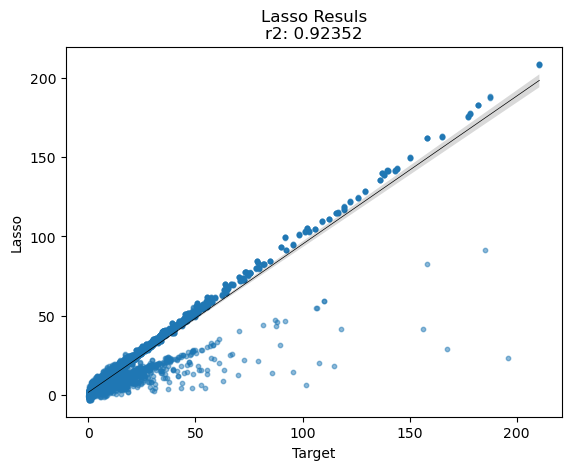

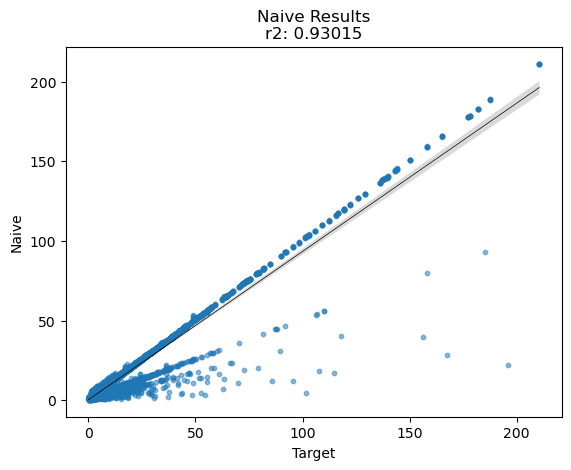





============ TEST MONTH 6 ============

 > Deaths_Lasso
  • MAE: 	2.98061
  • MedAE: 	2.1039
  • MSE: 	55.91894
  • RMSE: 	7.4779
  • r-squared: 	0.84052
  • relMedAE: 	1.5873
 > Deaths_naive
  • MAE: 	2.40457
  • MedAE: 	1.22057
  • MSE: 	55.331
  • RMSE: 	7.43848
  • r-squared: 	0.84219
  • relMedAE: 	1.0


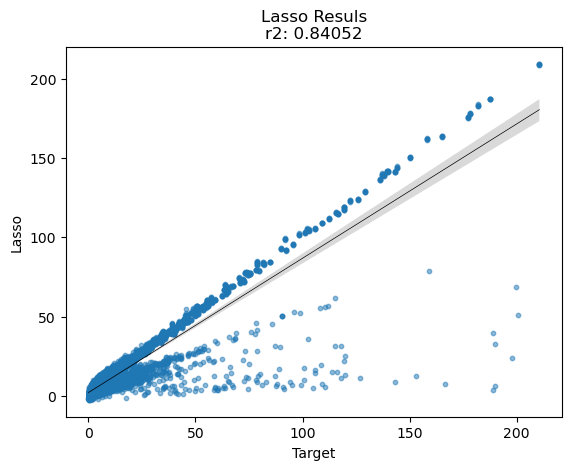

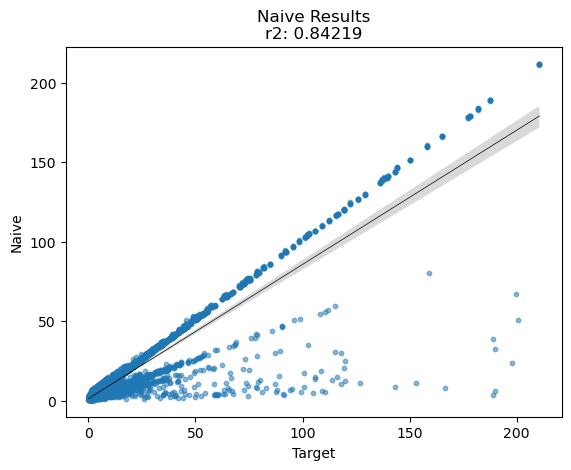





============ TEST MONTH 3 ============

 > Deaths_Lasso
  • MAE: 	6.94135
  • MedAE: 	5.03719
  • MSE: 	129.03505
  • RMSE: 	11.35936
  • r-squared: 	0.69639
  • relMedAE: 	1.15292
 > Deaths_naive
  • MAE: 	6.75547
  • MedAE: 	4.41095
  • MSE: 	135.62023
  • RMSE: 	11.64561
  • r-squared: 	0.68089
  • relMedAE: 	1.0


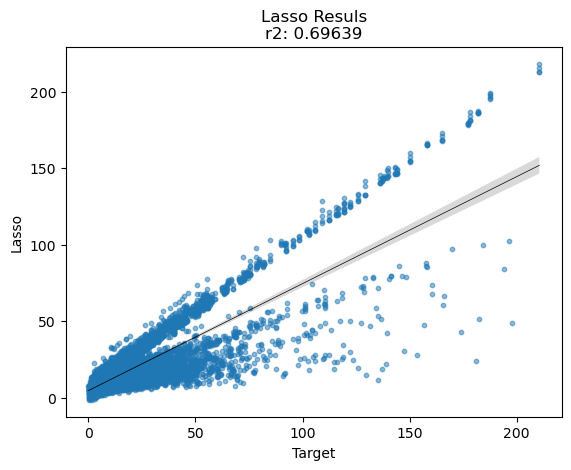

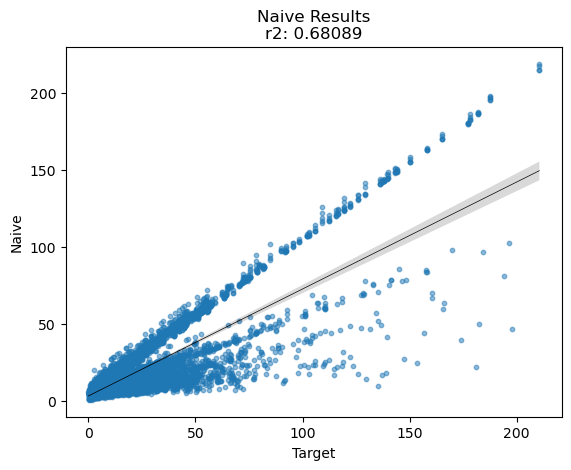





============ TEST MONTH 2 ============

 > Deaths_Lasso
  • MAE: 	5.57556
  • MedAE: 	3.40528
  • MSE: 	112.32142
  • RMSE: 	10.59818
  • r-squared: 	0.73232
  • relMedAE: 	1.19928
 > Deaths_naive
  • MAE: 	5.40536
  • MedAE: 	2.74834
  • MSE: 	118.75566
  • RMSE: 	10.89751
  • r-squared: 	0.71699
  • relMedAE: 	1.0


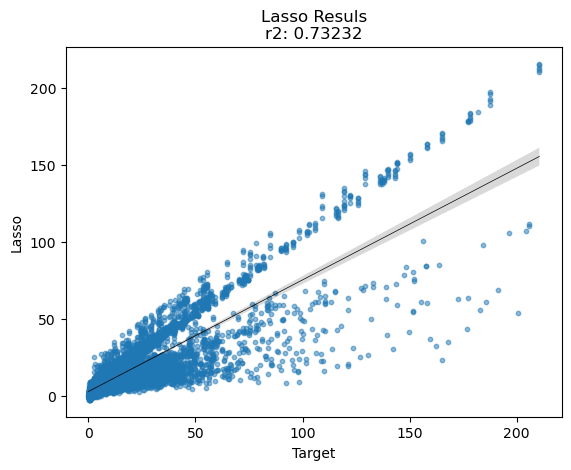

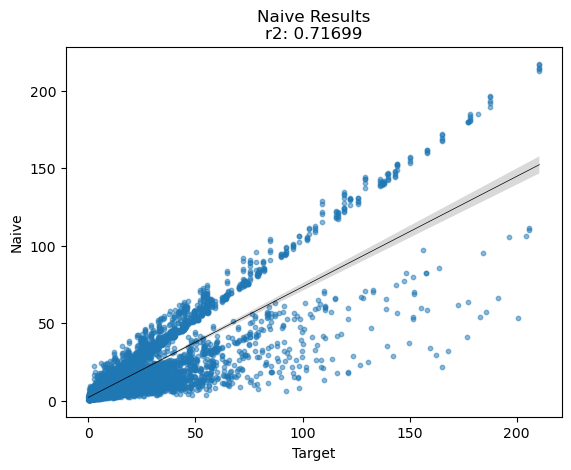





============ TEST MONTH 4 ============

 > Deaths_Lasso
  • MAE: 	6.09213
  • MedAE: 	4.32896
  • MSE: 	97.4797
  • RMSE: 	9.87318
  • r-squared: 	0.74031
  • relMedAE: 	1.1979
 > Deaths_naive
  • MAE: 	5.7894
  • MedAE: 	3.85582
  • MSE: 	100.26467
  • RMSE: 	10.01322
  • r-squared: 	0.7329
  • relMedAE: 	1.0


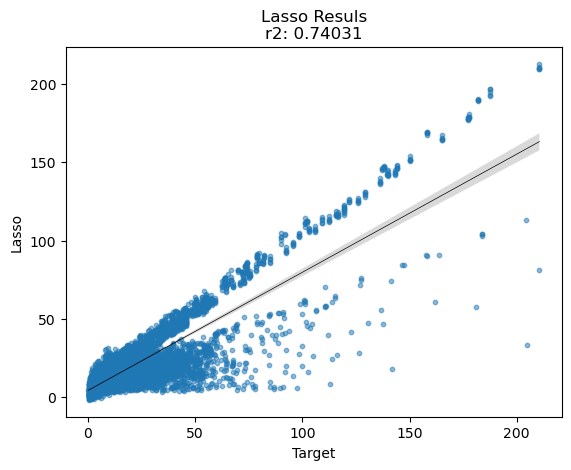

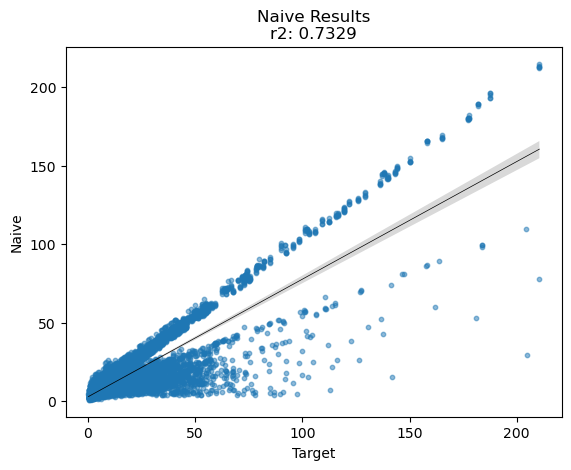

In [20]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression, BayesianRidge
random.seed(666)

# # # # # # # # # # # # # # # # # # # #
num_runs = 5
# alg = 'Bayesian Ridge'
# alg = 'ARD Regression'
# alg = 'Linear'
alg = 'Lasso'
data_frac = 1.0
# # # # # # # # # # # # # # # # # # # #

chunks = get_chunks(list(df.Date.unique()), num_runs)

## Pre-selected test-train splits to product a good mae and a bad mae
idc = random.sample(range(len(chunks)), num_runs)
# idc = [14,12]
# idc = [7]

models = []
preds = []
targets = []

for i,idx in enumerate(idc):
    
    ########## RUN MODEL ########## 
    
    df_train, df_test = get_date_chunked_splits(df, chunks, 
                                                idx, samp_frac=data_frac)
    
#     df_test = df_train
    
    ## Random split
#     from sklearn.model_selection import train_test_split
#     df_train, df_test = train_test_split(df, test_size=0.01, random_state=666)
    
#     feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
#                                     'State_pop','Ratio','Pop']
        
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
    if alg=='Linear':
        reg = LinearRegression().fit(X_train, y_train)
    elif alg=='Lasso':
        reg = Lasso(alpha=0.1).fit(X_train, y_train)
    elif alg=='Bayesian Ridge':
        reg = BayesianRidge(compute_score=True).fit(X_train, y_train)
    elif alg=='ARD Regression':
        reg = ARDRegression(compute_score=True).fit(X_train, y_train)
        
    models.append(reg)

    df_test[f'{alg}'] = reg.predict(X_test)

    ########## GET METRICS ##########

    model_names = [f'Deaths_{alg}', 'Deaths_naive']
    model_preds = [df_test[alg], df_test['Naive']]

    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)

    print(f'\n\n\n\n============ TEST MONTH {idx} ============\n')
    for k,v in metrics_dict.items():
        print(f' > {k}')
        for k2,v2 in v.items():
            if k2=='relMAE': 
                continue
            if k2=='r2':
                k3 = 'r-squared'
            else:
                k3 = k2
            print(f'  • {k3}: \t{round(v2,5)}')
            
            
   ########## PLOTS ########## 
    
    ## Regression plot
    r2 = round(metrics_dict[f'Deaths_{alg}']['r2'],5)
    relmae = round(metrics_dict[f'Deaths_{alg}']['relMAE'],5)
    line_plot(df_test, 'Target', f'{alg}', 
              title=f'{alg} Resuls\nr2: {r2}')
    
    ## Naive plot
    r2 = round(metrics_dict['Deaths_naive']['r2'],5)
    relmae = round(metrics_dict['Deaths_naive']['relMAE'],5)
    line_plot(df_test, 'Target', 'Naive', 
              title=f'Naive Results\nr2: {r2}')


In [ ]:
# fig_reg = LinearRegression().fit(df_test[['Target']], df_test[['Naive']])

# fig_reg.predict(df_test[['Target']])

# idx = df_test[['Naive']] > fig_reg.predict(df_test[['Target']])
# idx = idx["Naive"].values

# upper = df_test[idx]
# # print(upper)
# plt.scatter(upper['Target'], upper['Naive'])

# lower = df_test[~idx]
# plt.scatter(lower['Target'], lower['Naive'])

# plt.show()

# st_cols = [x for x in upper.columns if 'Is_' in x]
# upper_sts = upper[st_cols]

# df_original = pd.from_dummies(upper_sts, sep="_")
# df_original.columns = ['Postal']

# upper['Postal'] = df_original['Postal']
# upper

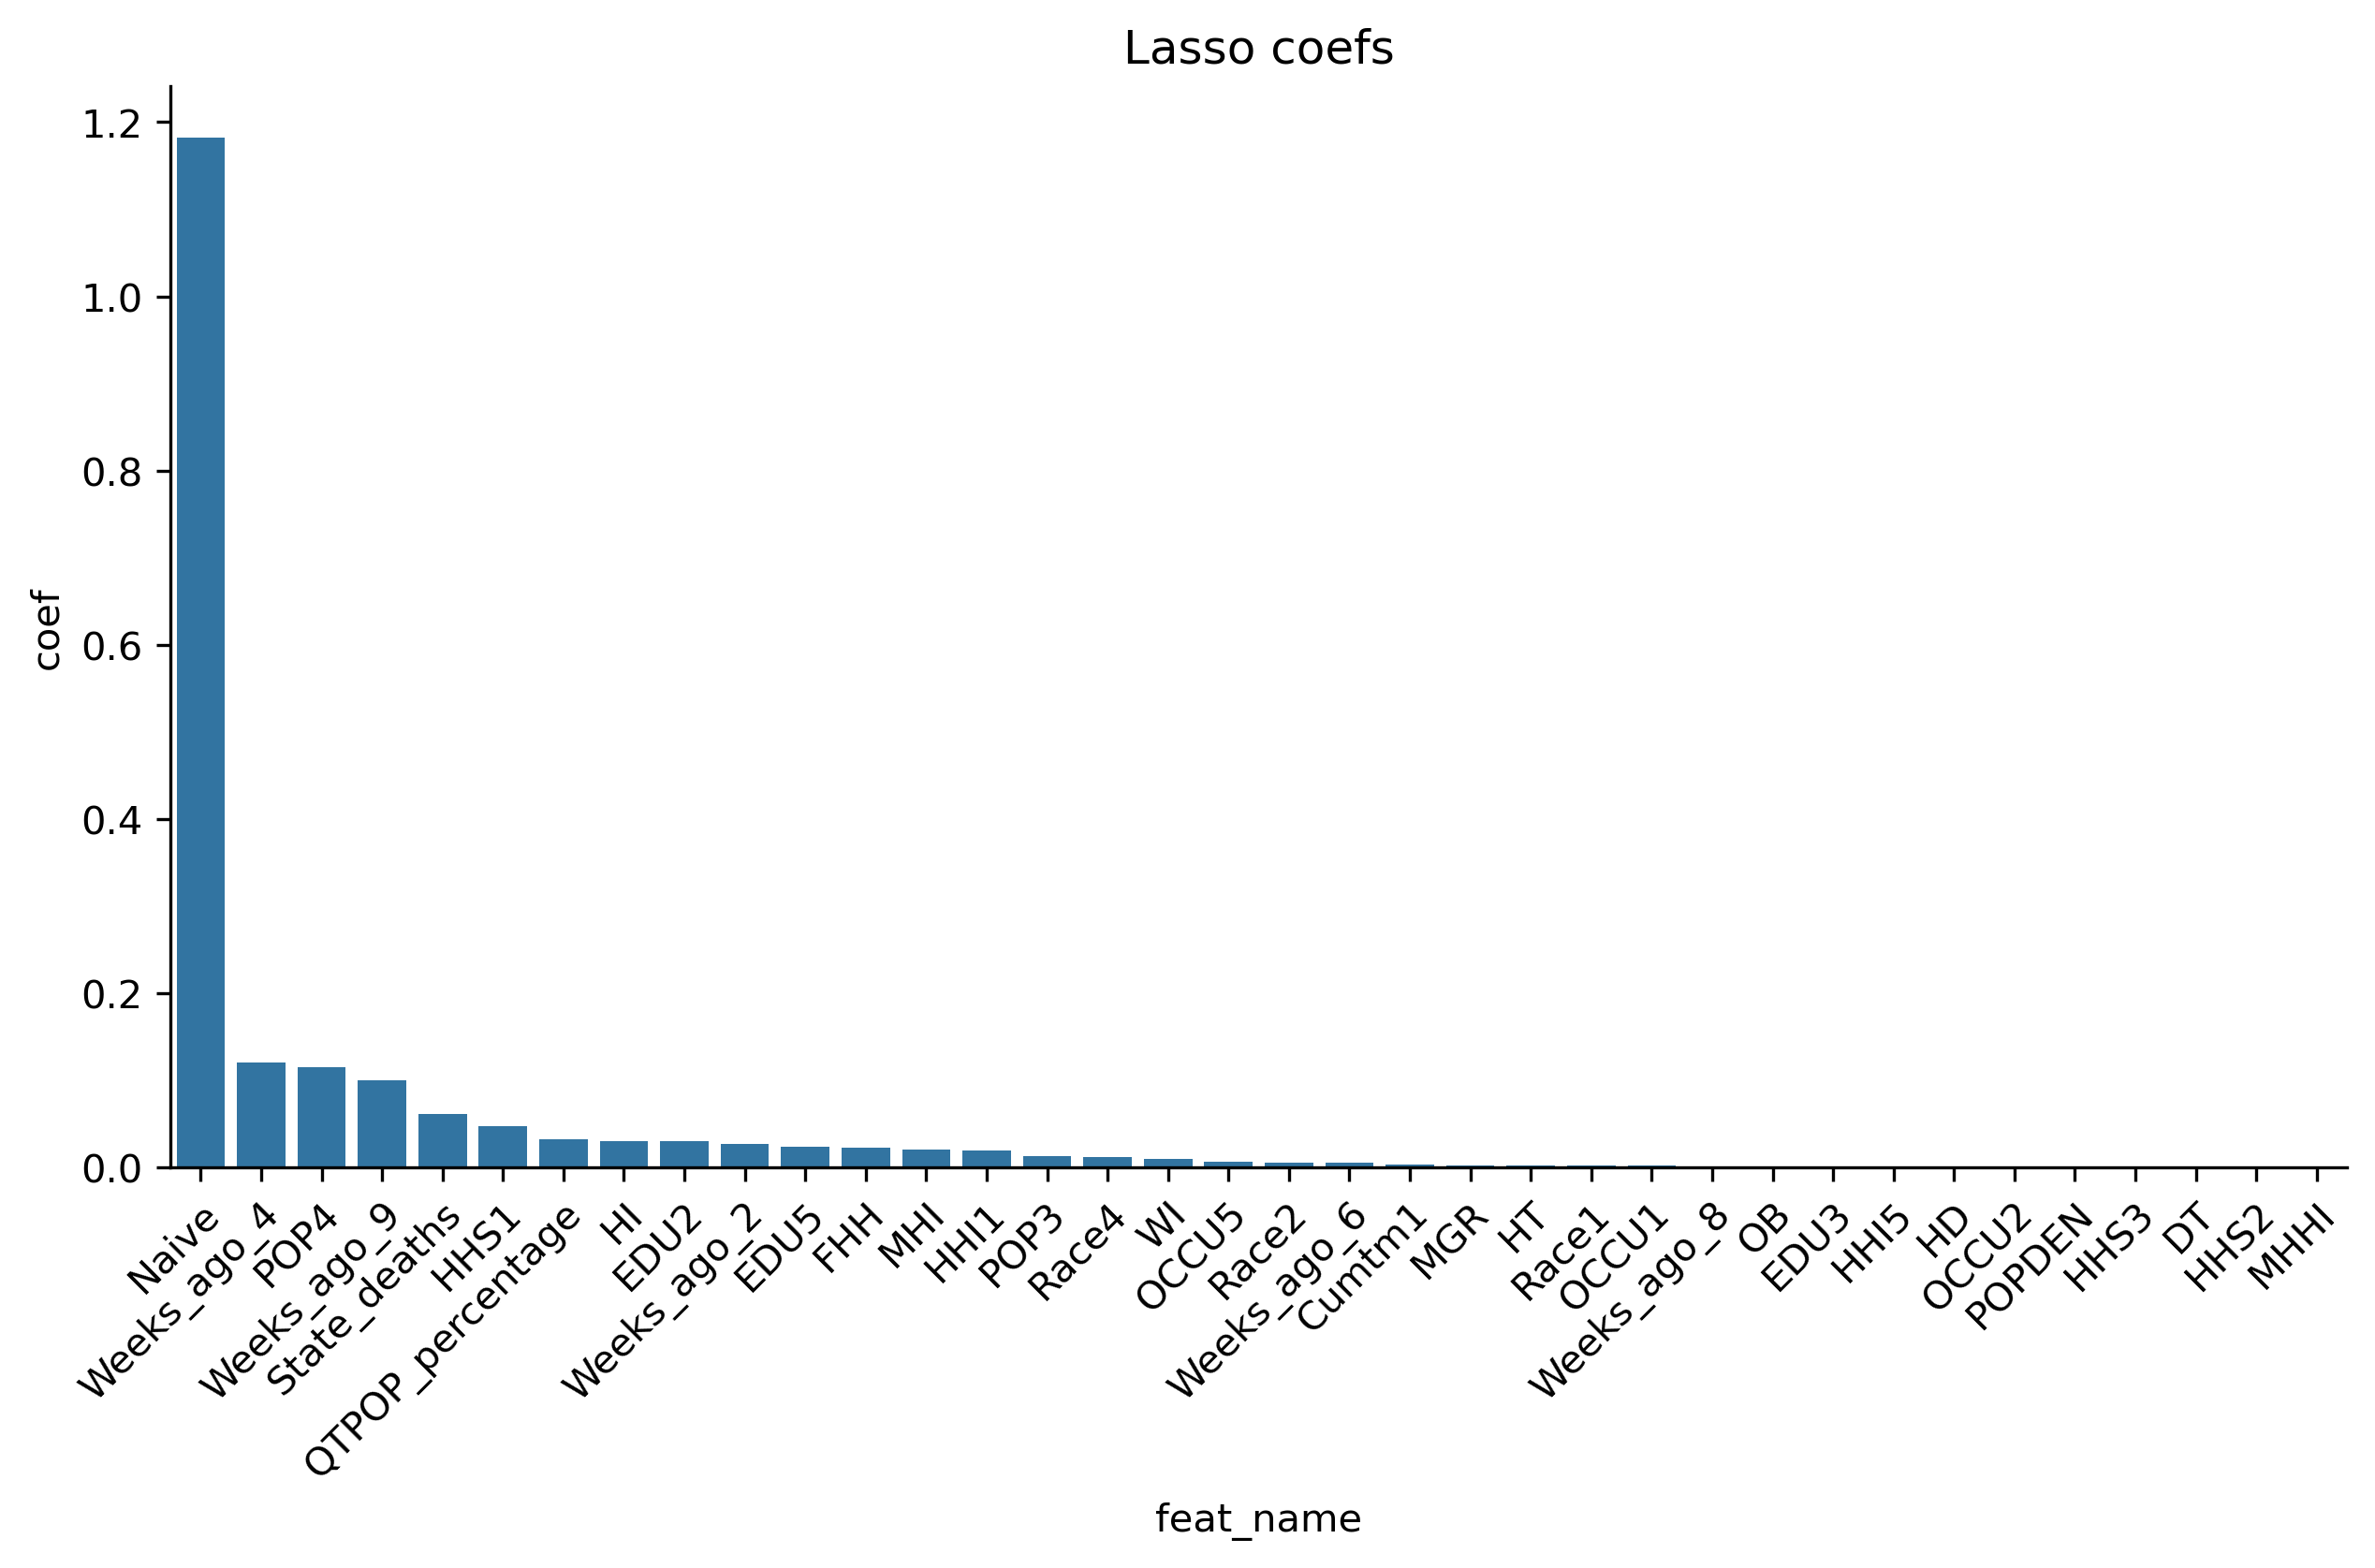

In [21]:
# # # # # # # # # #
how_many = 36
# # # # # # # # # #

# coef = abs(reg.coef_)
total_coefs = np.sum([abs(model.coef_) for model in models], axis=0) 
coef = total_coefs / num_runs

ind = np.argpartition(coef, -how_many)[-how_many:]
top = coef[ind]

df_coefs = X_train.iloc[:, ind]
which_feats = df_coefs.columns

res_df = pd.DataFrame([top, which_feats], index=['coef','feat_name'])
res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)

res_df = res_df[:how_many]

import seaborn as sns
import matplotlib.pyplot as plt


DPI = 300

plt.figure(figsize=(10,5))
sns.barplot(res_df, y="coef", x="feat_name", legend=False)
plt.title(f'{alg} coefs')
# plt.xticks(xticks, rotation=45)
plt.xticks(rotation=45,ha='right',wrap='True')

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
meow()

In [ ]:
df_test